In [1]:
# Standard modules
import pdb
import sys
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append("../..")

from simstackwrapper import SimstackWrapper
from simstacktoolbox import SimstackToolbox

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# This step is only necessary if you split the stacking into multiple chunks.  

If you split the stack into chunks, e.g.; 

; First Third 
* classification = {"split_type":"nuvrj", "redshift":{"id":"lp_zBEST", "bins":"[0.01, 0.5, 1.0, 1.5, 2.0]"}, "stellar_mass":{"id":"lp_mass_med", "bins":"[9.5, 10.0, 10.5, 11.0, 12.0]"}, "split_params":{"id":"sfg", "bins":{"UV-R":"restNUV-R", "R-J":"restR-J"}}  }

; Second Third

* classification = {"split_type":"nuvrj", "redshift":{"id":"lp_zBEST", "bins":"[2.0, 2.5, 3.0, 3.5, 4.0]"}, "stellar_mass":{"id":"lp_mass_med", "bins":"[9.5, 10.0, 10.5, 11.0, 12.0]"}, "split_params":{"id":"sfg", "bins":{"UV-R":"restNUV-R", "R-J":"restR-J"}}  }

; Third Third

* classification = {"split_type":"nuvrj", "redshift":{"id":"lp_zBEST", "bins":"[4.0, 5.0, 6.0, 8.0, 10.0]"}, "stellar_mass":{"id":"lp_mass_med", "bins":"[9.5, 10.0, 10.5, 11.0, 12.0]"}, "split_params":{"id":"sfg", "bins":{"UV-R":"restNUV-R", "R-J":"restR-J"}}  }

Then they need to be merged in order to analyze as one set.  This is a 4 step process
1. Make a new directory, pickle_dict, to store the merged pickle.  
2. Inside that directory you need to copy the config file (e.g., cosmos2020_farmer.ini) and **edit the redshift bins** to reflect the merged redshift bins.   So in this example it would look like
* classification = {"split_type":"nuvrj", "redshift":{"id":"lp_zBEST", "bins":"[0.01, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0]"}, "stellar_mass":{"id":"lp_mass_med", "bins":"[9.5, 10.0, 10.5, 11.0, 12.0]"}, "split_params":{"id":"sfg", "bins":{"UV-R":"restNUV-R", "R-J":"restR-J"}}  }
3. Create a dictionary containing the names of the directories of the stacked fluxes, the merged directory, and the name of the config file.  See below for example.
4. Run merge_stack_and_catalog_pickles(pickle_dict)

## Farmer: z0-10 x 4M X 100boots

In [2]:
pickle_file_dict = {'stack_dirs': ['cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2p0_X_4_foregnd_atonce_bootstrap_1-150', 
                                   'cosmos2020_farmer_nuvrj_2_2p5_3_3p5_4p0_X_4_foregnd_atonce_bootstrap_1-150',
                                   'cosmos2020_farmer_nuvrj_4_5_6_8_10p0_X_4_foregnd_atonce_bootstrap_1-150'], 
                    'underscore_suffix': '', 
                    'merged_dir': 'cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10_X_4_foregnd_atonce_bootstrap_1-150',
                    'config_filename': 'cosmos2020_farmer.ini',
                    'pickle_path':os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities")}

In [3]:
def merge_stack_and_catalog_pickles(pickle_dict, keep_full_catalog=True, save_pickle=True, overwrite_pickle=False):
    
    pickle_path_combined = os.path.join(pickle_dict['pickle_path'],pickle_dict['merged_dir']+pickle_dict['underscore_suffix'])
    path_save_pickle = os.path.join(pickle_path_combined,pickle_dict['merged_dir']+'.pkl')
    
    if os.path.isfile(path_save_pickle) and not overwrite_pickle:
        return SimstackToolbox.import_saved_pickles(path_save_pickle)
    
    for iobj, path_obj in enumerate(pickle_dict['stack_dirs']):
        path_object = os.path.join(pickle_dict['pickle_path'],path_obj+pickle_dict['underscore_suffix'],path_obj+'.pkl')

        if os.path.isfile(path_object):
            temp_object = SimstackToolbox.import_saved_pickles(path_object)
        else:
            print(path_object ,' does not exist')
            break
                
        if not iobj:
            merge_object = temp_object
        else:
            merge_object.combine_objects(temp_object)

        if keep_full_catalog:
            path_ini_file = os.path.join(pickle_path_combined, pickle_dict['config_filename'])
            if os.path.isfile(path_ini_file):
                catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
                merge_object.catalog_dict['tables']['full_table'] = catalog_object.catalog_dict['tables']['full_table']
            else:
                print(path_ini_file ,' does not exist')
                break
        
        if save_pickle:            
            SimstackToolbox.save_to_pickles(path_save_pickle, merge_object)
                
    return merge_object

In [4]:
# Merge and Save to Pickle
save_pickle = True
merged_object = merge_stack_and_catalog_pickles(pickle_file_dict, save_pickle=save_pickle, overwrite_pickle=True)

# OPTIONALLY INSPECT MERGED FLUXES

In [5]:
from simstackresults import SimstackResults
merged_object = SimstackResults(merged_object)

In [6]:
merged_object.parse_results(catalog_object=merged_object, estimate_mcmcs=False)

In [7]:
from simstackplots import SimstackPlots
merged_object = SimstackPlots(merged_object)

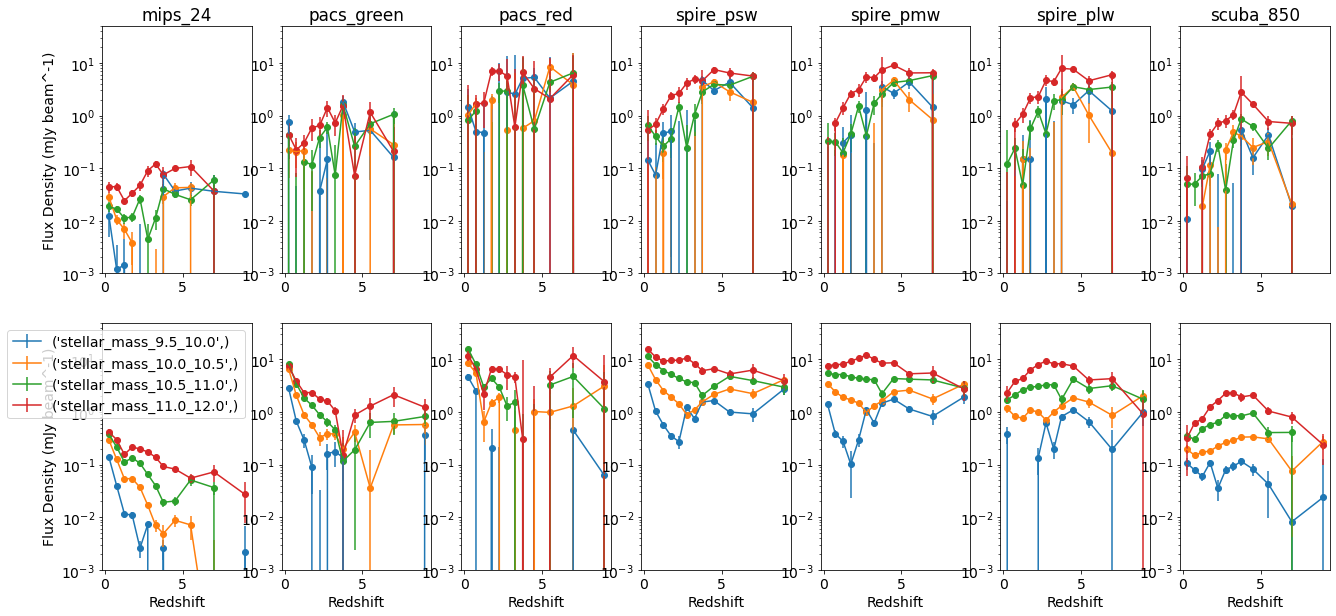

In [8]:
merged_object.plot_flux_densities()

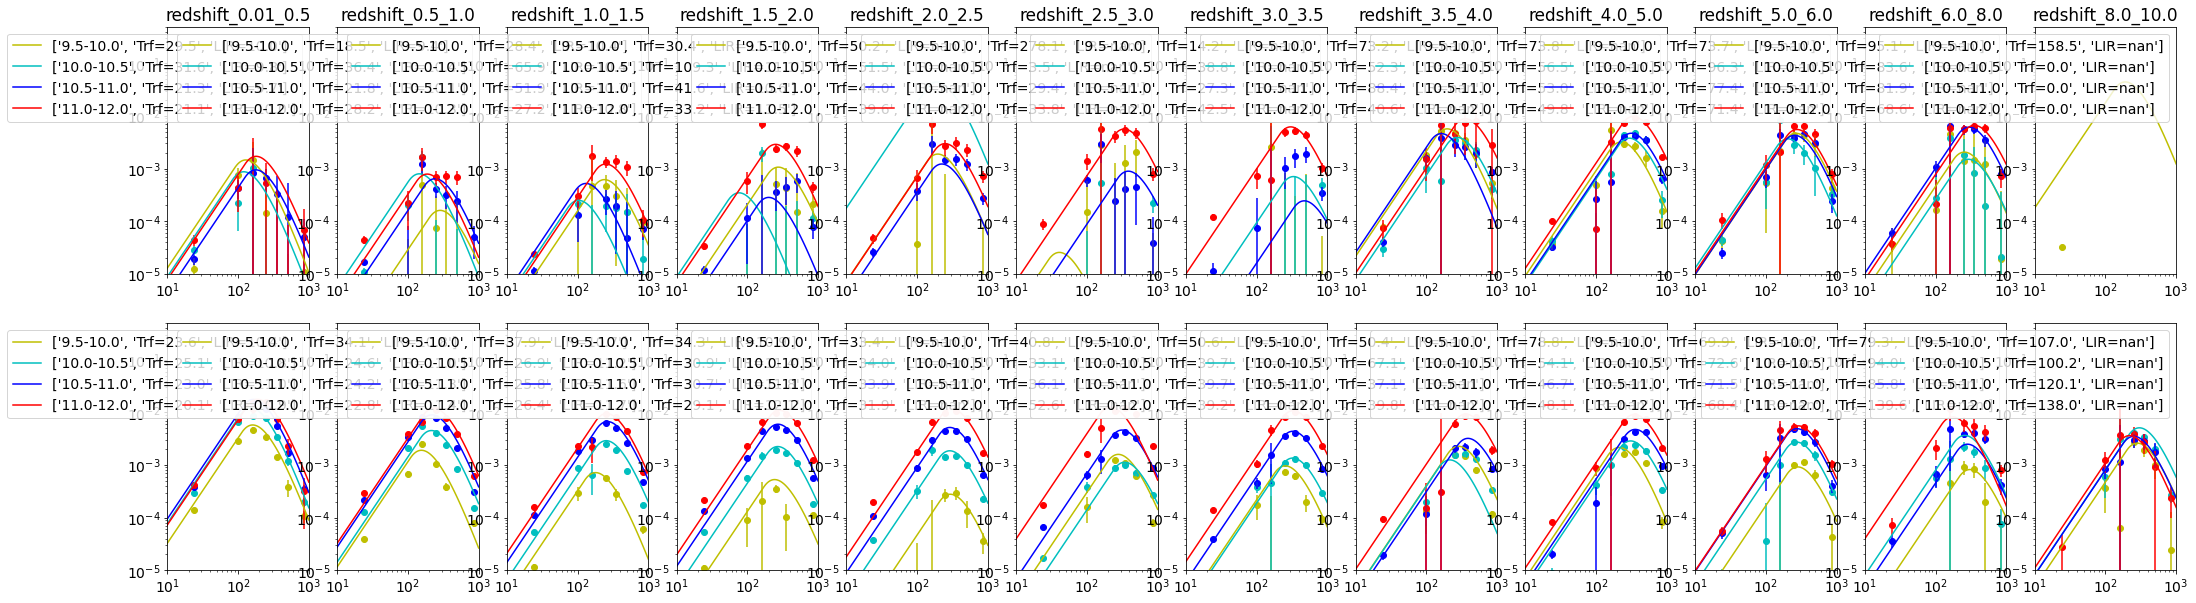

In [9]:
merged_object.plot_seds(merged_object.results_dict['sed_bootstrap_results_dict'])